# Price Regression

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import NMF
import itertools

import sys
sys.path.append('../utilities')
from data_utils import *
from ml_utils import *
from stats_utils import *

#### Read and Prepare data

In [2]:
# read cleaned data
skin_care_df = pd.read_csv('../data_cleaning/skin_care_cleaned.csv')
body_care_df = pd.read_csv('../data_cleaning/body_care_cleaned.csv')
makeup_df = pd.read_csv('../data_cleaning/makeup_cleaned.csv')

# merge skin-care, body-care and makeup table
df = pd.concat([skin_care_df,body_care_df,makeup_df], sort=False).reset_index(drop=True)

# drop outlier
df = df.loc[df['price']<300].reset_index(drop=True)

#### Add more features
* Count ingredients that are "xxx extract", peptide, "xxx oil" --- these are special categories we found in EDA that may be associated with price.
* Individule ingredient binary count --- the matrix is sparse and has too many columns, we cannot use it directly, so we will use chi2 test to pick a few that are important.
* Similar to the idea of tf-idf, we can turn our individule ingredient count to "if-ipf"(ingredient frequency - inverse product frequency), which penalize common ingredients. Then we use NMF to get 50 compenents as features.

In [3]:
# count ingredients that that are "xxx extract", peptide, "xxx oil"
df['count_extract'] = df['inactive_ingredient_list'].apply(count_pattern, pattern='extract')
df['count_peptide'] = df['inactive_ingredient_list'].apply(count_pattern, pattern='peptide')
df['count_oil'] = df['inactive_ingredient_list'].apply(count_pattern, pattern='oil')

# count ingredient
ingredient_count_df = get_matching_ingredient_count(df)

# select important individule ingredient using chi-square test
interesting_ingredients = []
for col in ingredient_count_df.columns.values:
    count_ingredient = ingredient_count_df[col].sum()
    if count_ingredient > 100 and count_ingredient < 500:
       interesting_ingredients.append(col) 
    
price_band, bins = pd.qcut(df['price'], q=[0, 0.2, 0.4, 0.6, 0.8, 1], labels=False, retbins=True)
ingredient_count_df['price_band'] = price_band.reset_index(drop=True)

results = chi2_contingency(ingredient_count_df, interesting_ingredients, 'price_band').sort_values('p-value')
top_ingredients = results.index.values[:50]
print("individule ingredient picked:\n", top_ingredients)

# create "if-ipf"(ingredient frequency - inverse product frequency) and use 50 NMF compenents as features
if_ipf = TfidfTransformer().fit_transform(ingredient_count_df)
if_ipf_nmf = NMF(n_components=50).fit_transform(if_ipf)
if_ipf_nmf_df = pd.DataFrame(if_ipf_nmf)
if_ipf_nmf_df = if_ipf_nmf_df.add_prefix('if_pif_nmf_') 

# merge the new features to dataframe
df = pd.concat([df, if_ipf_nmf_df, ingredient_count_df[top_ingredients]], axis=1)
df.head()

/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/contingency.py:242: RuntimeWarning: invalid value encountered in less
  if np.any(observed < 0):


individule ingredient picked ['acetyl hexapeptide-8' 'algae extract' 'caffeine'
 'palmitoyl oligopeptide' 'hydrogenated lecithin' 'alpha isomethyl ionone'
 'trehalose' 'linoleic acid' 'phospholipid' 'PEG-8' 'polysilicone-11'
 'butylparaben' 'palmitoyl tetrapeptide-7' 'retinol'
 'tetrahexyldecyl ascorbate' 'urea' 'ascorbyl palmitate' 'polysaccharide'
 'bromelain' 'hydrolyzed wheat protein' 'Palmitoyl Tripeptide-38'
 'hydrolyzed algae extract' 'Calluna vulgaris flower extract'
 'butylphenyl methylpropional' 'lysine' 'acetyl glucosamine'
 'sodium metabisulfite' 'acetic acid' 'glycolic acid' 'polysorbate 80'
 'Scutellaria baicalensis extract' 'isobutylparaben'
 'hydrolyzed soy protein' 'arginine' 'polymethylsilsesquioxane'
 'DMDM hydantoin' 'cholesterol' 'glyceryl polymethacrylate'
 'sorbitan stearate' 'petrolatum' 'dipotassium glycyrrhizate'
 'propylene glycol dicaprylate' 'cyclohexasiloxane' 'sorbitol'
 'saccharide isomerate' 'phenyl trimethicone' 'grape seed extract'
 'sucrose' 'sodium 

,product_names,product_category,brand,ingredient,size,price,size_num,size_unit,avg_price,active_ingredient,...,dipotassium glycyrrhizate,propylene glycol dicaprylate,cyclohexasiloxane,sorbitol,saccharide isomerate,phenyl trimethicone,grape seed extract,sucrose,sodium gluconate,retinyl retinoate
0,Clear Complexion Spot Treatment,Acne & Blemish Treatment,Merle Norman,"Active: Salicylic Acid (2%), Other: Alcohol D...",0.50 fl. oz.,20.00,15.0,ml,1.333333,"Salicylic Acid (2%),",...,0,0,0,0,0,0,0,0,0,0
1,Acne Solutions Emergency Gel Lotion,Acne & Blemish Treatment,Clinique,"Active: Benzoyl Peroxide (5%), Other: Water P...",0.50 fl. oz.,17.00,15.0,ml,1.133333,"Benzoyl Peroxide (5%),",...,0,0,0,0,0,0,0,1,0,0
2,RESIST Daily Pore-Refining Solution 2% BHA,Acne & Blemish Treatment,Paula's Choice Skincare,"Water (Aqua), Dipropylene Glycol, Salicylic ...",3.00 fl. oz.,33.00,89.0,ml,0.370787,NaN,...,1,0,0,0,0,0,0,0,0,0
3,Max Complexion Correction Pads,Acne & Blemish Treatment,Peter Thomas Roth,"Active: Salicylic Acid (2%), Other: Alcohol D...",60.00,40.00,60.0,NaN,0.666667,"Salicylic Acid (2%),",...,0,0,0,0,0,0,0,0,0,0
4,Naturals Acne Spot Treatment,Acne & Blemish Treatment,Neutrogena,Active Ingredient: Salicylic Acid 1%. Inactive...,0.75 fl. oz.,8.49,22.0,ml,0.385909,Salicylic Acid 1%.,...,0,0,0,0,0,0,0,0,0,0


In [4]:
target = 'price'
meanenc_feats = ['product_category', 'brand', 'size_unit']
gen_features = ['product_category_mean_encode', 'brand_mean_encode', 'size_num', 'size_unit_mean_encode']
ingredient_features = ['n_inactive_ingredient','n_active_ingredient','active_mean_rating', 'inactive_mean_rating', 'inactive_mean_rating_w1','inactive_mean_rating_w2']
ingredient_features += [f_ for f_ in df.columns.values if f_.find('count')>=0]
ingredient_features += [f_ for f_ in df.columns.values if f_.find('_nmf_')>=0]
ingredient_features += list(top_ingredients)

#### target encoding categorical features

In [5]:
train, test = train_test_split(df)
folds = KFold(5, random_state=777)

pd.options.mode.chained_assignment = None
for col in meanenc_feats:
    train[col+'_mean_encode'] = 0.
    test[col+'_mean_encode'] = 0.
    SMOOTHING = test[~test[col].isin(train[col])].shape[0]/test.shape[0]
    _, test[col+'_mean_encode'] = target_encode(train[col], 
                                      test[col], 
                                      target=train[target], 
                                      min_samples_leaf=20,
                                      smoothing=SMOOTHING,
                                      noise_level=0.02)
    for f, (vis_index, blind_index) in enumerate(folds.split(train, train[target])):
        _, train[col+'_mean_encode'].iloc[blind_index] = target_encode(train[col].iloc[vis_index], 
                                                            train[col].iloc[blind_index], 
                                                            target=train[target].iloc[vis_index], 
                                                            min_samples_leaf=20,
                                                            smoothing=SMOOTHING,
                                                            noise_level=0.02)     
        


../utilities/ml_utils.py:161: RuntimeWarning: overflow encountered in exp
  smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))


#### First let's build a baseline model just using brand, category, size features.

In [6]:
features = gen_features
X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

model = LGBMRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, lambda_l2=0.1)
y_train_pred = oof_preds(X_train.values, y_train.values, model, folds=folds, return_prob=False)

model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

ev_train = explained_variance_score(y_train, y_train_pred)
ev_test = explained_variance_score(y_test, y_test_pred)

print("number of features:",len(features))
print("rmse: (train cv) %.3f, (test) %.3f"%(rmse_train, rmse_test))
print("explained variance: (train cv) %.3f, (test) %.3f"%(ev_train, ev_test))

number of features: 4
rmse: (train cv) 24.560, (test) 21.362
explained variance: (train cv) 0.470, (test) 0.541


#### Use ingredient features to train the model

In [7]:
features = ingredient_features
X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

model = LGBMRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, lambda_l2=0.1)
y_train_pred = oof_preds(X_train.values, y_train.values, model, folds=folds, return_prob=False)

model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

ev_train = explained_variance_score(y_train, y_train_pred)
ev_test = explained_variance_score(y_test, y_test_pred)

print("number of features:",len(features))
print("rmse: (train cv) %.3f, (test) %.3f"%(rmse_train, rmse_test))
print("explained variance: (train cv) %.3f, (test) %.3f"%(ev_train, ev_test))

number of features: 171
rmse: (train cv) 19.747, (test) 18.223
explained variance: (train cv) 0.657, (test) 0.666


#### Now use all features, and see how much can they improve our model

In [8]:
features = gen_features + ingredient_features
X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

model = LGBMRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, lambda_l2=0.1)
y_train_pred = oof_preds(X_train.values, y_train.values, model, folds=folds, return_prob=False)

model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

ev_train = explained_variance_score(y_train, y_train_pred)
ev_test = explained_variance_score(y_test, y_test_pred)

print("number of features:",len(features))
print("rmse: (train cv) %.3f, (test) %.3f"%(rmse_train, rmse_test))
print("explained variance: (train cv) %.3f, (test) %.3f"%(ev_train, ev_test))

number of features: 175
rmse: (train cv) 18.579, (test) 16.261
explained variance: (train cv) 0.697, (test) 0.734


#### scatter plot for predicted vs. true price

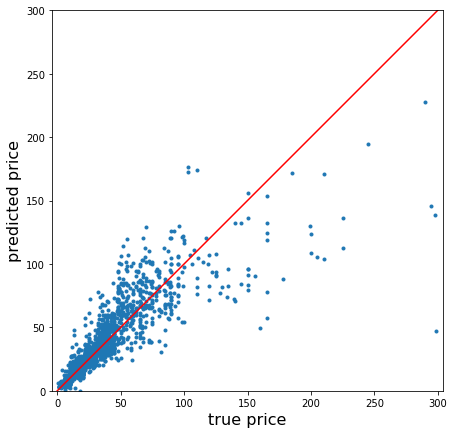

In [9]:
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_test_pred, marker='.')
plt.plot([0,300],[0,300],color='r')
plt.axis('equal')
plt.xlim(0,300)
plt.ylim(0,300)
plt.xlabel('true price',fontsize=16)
plt.ylabel('predicted price',fontsize=16)
plt.show()

#### Plot feature importance

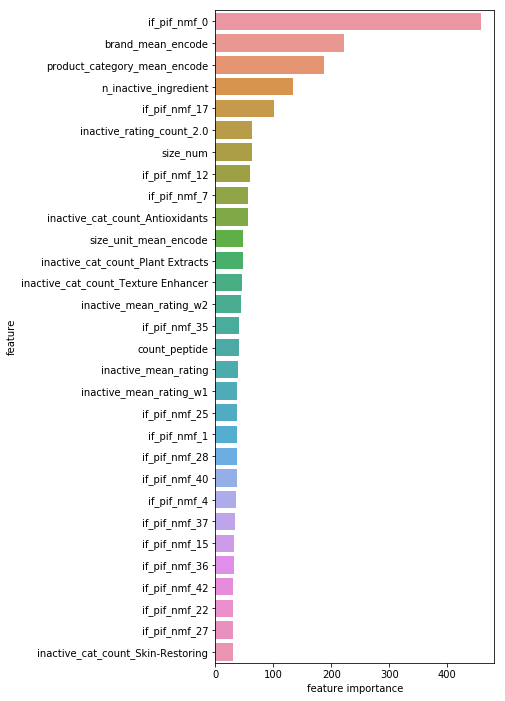

In [10]:
feature_importance_df = pd.DataFrame()
feature_importance_df['feature'] = features
feature_importance_df['feature importance'] = model.feature_importances_
feature_importance_df = feature_importance_df.sort_values('feature importance', ascending=False)
plt.figure(figsize=(5,12))
sns.barplot(x='feature importance', y='feature', data=feature_importance_df.iloc[:30])
plt.show()